# ***Plant Diseases Classification***


---



**Primary Objective:** Develop a robust binary classifier to distinguish
between "Healthy" and "Unhealthy" crop leaves using a limited set of
labeled data and a large pool of unlabeled images.


---



**Educational Goals:**
● Learn the mechanics of transfer learning and fine-tuning in Computer
Vision.
● Implement semi-supervised learning (pseudo-labeling) to leverage
unused data.
● Learn resource-efficient training on limited hardware.



---

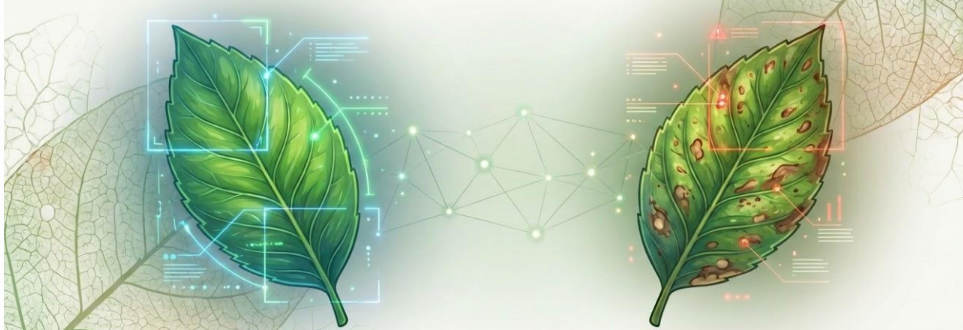

In [ ]:
import os
!gdown 1BOGeKKva4oviQs0FGfPKq2uVz20i8pd5 -O plant_disease.zip; unzip plant_disease.zip

In [ ]:
import os

# DATA_ROOT = '/kaggle/working' Kaggle
DATA_ROOT = '/content' # Google Colab
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VAL_DIR   = os.path.join(DATA_ROOT, 'val')
TEST_DIR  = os.path.join(DATA_ROOT, 'test')
UNLABELED_DIR = os.path.join(DATA_ROOT, 'unlabeled')

# Task – Baseline


---



***Data Familiarization & EDA:*** Explore image distributions, class balance (Healthy vs Unhealthy), and visualize samples to identify visual disease patterns.

Всього знайдено зображень: 5800


/tmp/ipython-input-2118723238.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='split', data=df, palette='viridis')


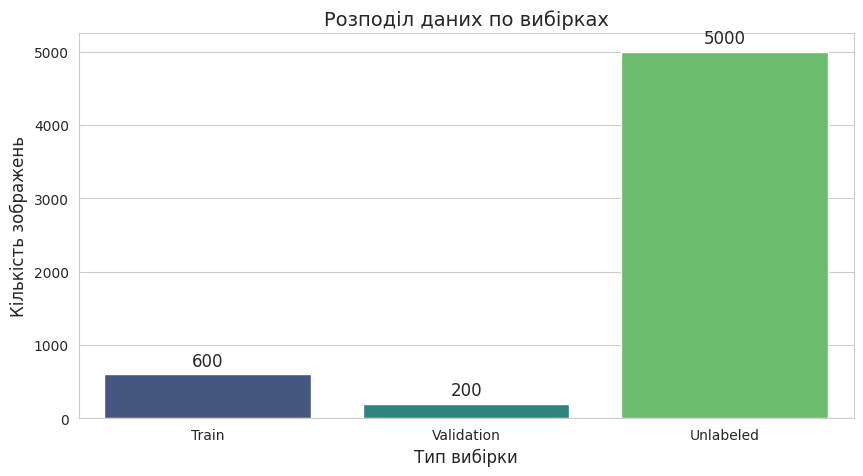

/tmp/ipython-input-2118723238.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_df, palette='Set2')


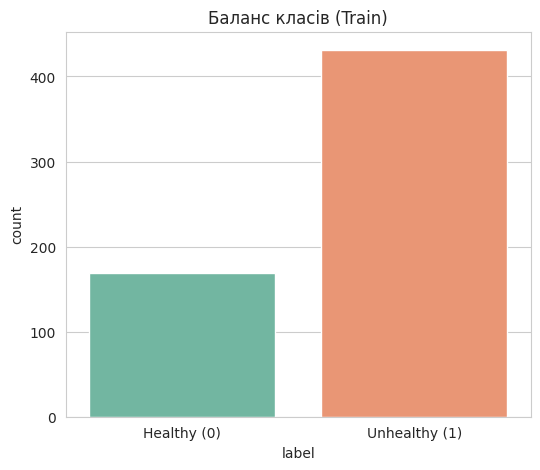

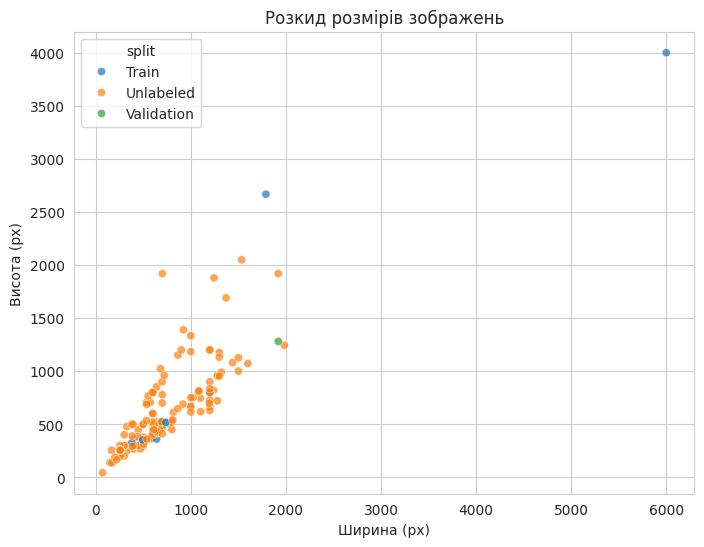

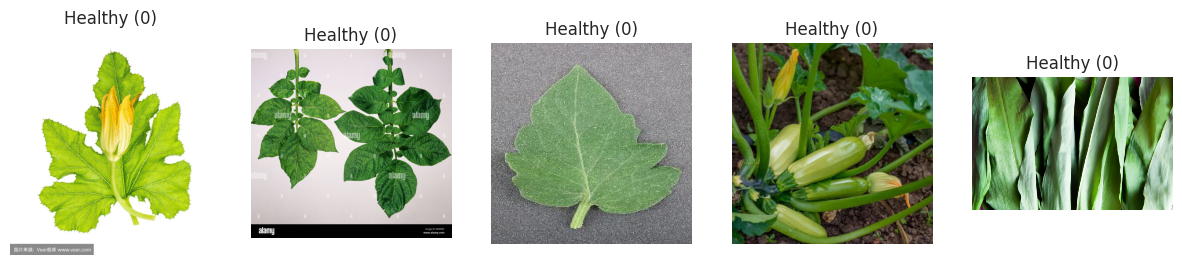

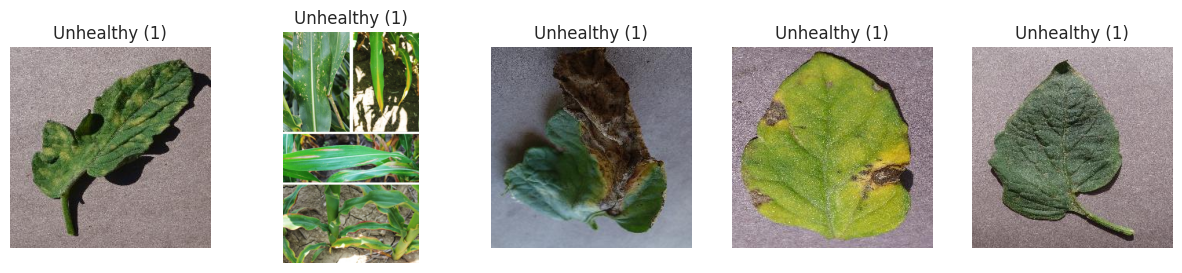

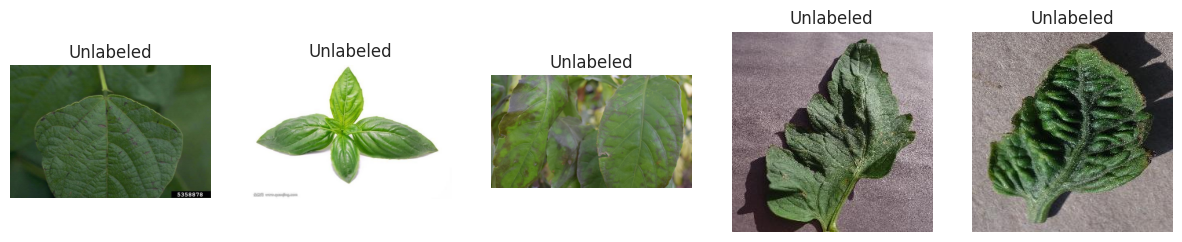

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from PIL import Image
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def df_eda(train_path, val_path, unlabeled_path):
    data = []

    def scan_folder(path, split_name):
        if not os.path.exists(path):
            print(f"Папка {split_name} ({path}) не знайдена!")
            return

        # package Train/Val
        subfolders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

        if subfolders:
            for label in subfolders:
                folder_full_path = os.path.join(path, label)
                files = glob.glob(os.path.join(folder_full_path, "*.*"))
                for f in files:
                    simple_label = 'Healthy (0)' if 'healthy' in label.lower() or label == '0' else 'Unhealthy (1)'
                    data.append({'split': split_name, 'label': simple_label, 'path': f})

        # unlabeled
        else:
            files = glob.glob(os.path.join(path, "*.*"))

            if not files and os.path.exists(os.path.join(path, "images")):
                 files = glob.glob(os.path.join(path, "images", "*.*"))

            for f in files:
                data.append({'split': split_name, 'label': 'Unknown', 'path': f})

    scan_folder(train_path, 'Train')
    scan_folder(val_path, 'Validation')
    scan_folder(unlabeled_path, 'Unlabeled')

    global df
    df = pd.DataFrame(data)

    if df.empty:
        print("Дані не знайдено")
        return

    print(f"Всього знайдено зображень: {len(df)}")

    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x='split', data=df, palette='viridis')
    plt.title("Розподіл даних по вибірках", fontsize=14)
    plt.xlabel("Тип вибірки", fontsize=12)
    plt.ylabel("Кількість зображень", fontsize=12)
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=12)
    plt.show()

    train_df = df[df['split'] == 'Train']
    if not train_df.empty:
        plt.figure(figsize=(6, 5))
        sns.countplot(x='label', data=train_df, palette='Set2')
        plt.title("Баланс класів (Train)")
        plt.show()

    sample_df = df.sample(min(300, len(df)))
    widths, heights = [], []

    for p in sample_df['path']:
        try:
            with Image.open(p) as img:
                widths.append(img.width)
                heights.append(img.height)
        except:
            pass

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=widths, y=heights, hue=sample_df['split'], alpha=0.7)
    plt.title("Розкид розмірів зображень")
    plt.xlabel("Ширина (px)")
    plt.ylabel("Висота (px)")
    plt.show()

    def show_grid(subset, title_filter=None):
        subset_df = df[df['split'] == subset]
        if title_filter:
            subset_df = subset_df[subset_df['label'] == title_filter]

        if subset_df.empty: return

        paths = subset_df.sample(min(5, len(subset_df)))['path'].values

        plt.figure(figsize=(15, 3))
        for i, p in enumerate(paths):
            plt.subplot(1, 5, i+1)
            plt.imshow(Image.open(p))
            plt.axis('off')
            plt.title(title_filter if title_filter else subset)
        plt.show()

    show_grid('Train', 'Healthy (0)')
    show_grid('Train', 'Unhealthy (1)')
    show_grid('Unlabeled')

df_eda(TRAIN_DIR, VAL_DIR, UNLABELED_DIR)

# CONCLUSION



1.   Train: 600, Val: 200, Unlabeled: 5000. It's **data scarcity**. => unsupervised learning
2.   Healthy in training data in 2.7 smaller than unhealthy. **Classes imbalance. => need a weight in loss function.**
3. Big dispersion in photos size ( from ~250 px to 2500 px)
4. ??** Spurious Correlation** (light, space, etc.)
5.



---





**Identifying visual disease patterns**

Processing Unhealthy: 100%|██████████| 50/50 [00:00<00:00, 92.54it/s]
/tmp/ipython-input-131788915.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Healthy', 'Unhealthy'])


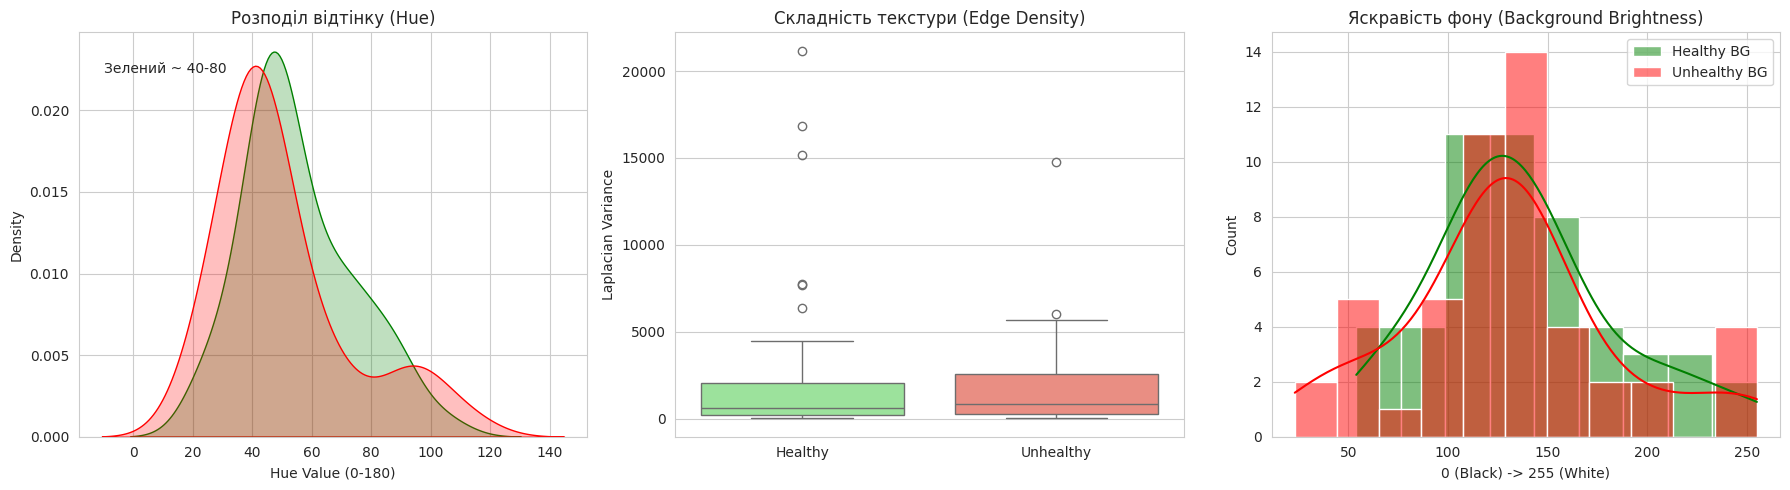

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

def analyze_patterns_advanced(df):
    healthy_paths = df[df['label'] == 'Healthy (0)'].sample(min(50, len(df)))['path'].values
    unhealthy_paths = df[df['label'] == 'Unhealthy (1)'].sample(min(50, len(df)))['path'].values

    h_hues, u_hues = [], []       # Color
    h_bg, u_bg = [], []           # Background
    h_texture, u_texture = [], [] # Complexity

    def get_metrics(paths, is_healthy):
        for p in tqdm(paths, desc=f"Processing {'Healthy' if is_healthy else 'Unhealthy'}"):

            img = cv2.imread(p)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # --- 1. COLOR ---
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

            # Saturation > 20
            mask = hsv[:,:,1] > 20
            if np.sum(mask) > 0:
                avg_hue = np.mean(hsv[:,:,0][mask])
                if is_healthy: h_hues.append(avg_hue)
                else: u_hues.append(avg_hue)

            # --- 2. BACKGROUND ---
            # 10x10 px from 4 angles
            h, w, _ = img.shape
            corners = [
                img[0:10, 0:10], img[0:10, w-10:w],
                img[h-10:h, 0:10], img[h-10:h, w-10:w]
            ]

            avg_bg_color = np.mean([np.mean(c, axis=(0,1)) for c in corners], axis=0)
            bg_gray = 0.299*avg_bg_color[0] + 0.587*avg_bg_color[1] + 0.114*avg_bg_color[2]

            if is_healthy: h_bg.append(bg_gray)
            else: u_bg.append(bg_gray)

            # --- 3. Laplacian Variance ---
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            score = cv2.Laplacian(gray, cv2.CV_64F).var()

            if is_healthy: h_texture.append(score)
            else: u_texture.append(score)

    get_metrics(healthy_paths, True)
    get_metrics(unhealthy_paths, False)

    # --- Graphics ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Color
    sns.kdeplot(h_hues, ax=axes[0], color='green', fill=True, label='Healthy')
    sns.kdeplot(u_hues, ax=axes[0], color='red', fill=True, label='Unhealthy')
    axes[0].set_title("Розподіл відтінку (Hue)")
    axes[0].set_xlabel("Hue Value (0-180)")
    axes[0].text(0.05, 0.9, "Зелений ~ 40-80", transform=axes[0].transAxes)

    # Complexity
    sns.boxplot(data=[h_texture, u_texture], ax=axes[1], palette=['lightgreen', 'salmon'])
    axes[1].set_xticklabels(['Healthy', 'Unhealthy'])
    axes[1].set_title("Складність текстури (Edge Density)")
    axes[1].set_ylabel("Laplacian Variance")

    # Brightness
    sns.histplot(h_bg, ax=axes[2], color='green', alpha=0.5, label='Healthy BG', kde=True)
    sns.histplot(u_bg, ax=axes[2], color='red', alpha=0.5, label='Unhealthy BG', kde=True)
    axes[2].set_title("Яскравість фону (Background Brightness)")
    axes[2].set_xlabel("0 (Black) -> 255 (White)")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

analyze_patterns_advanced(df)

**Disease Patterns**

1.   Healthy plants have high pick in interval 40-60(green color). Unhealthy plants have a wider dispersion. Bias in orange/red color. => **Color is a strong feature.**
2.  Healthy plants hasn't noise as unhealthy.=> **Spots, holes can be a feature for model.**
3. Dataset have problems with brightness. Trained datasets have annormal correlation with brightness 130-140. => **Need a augmentation**.


---



**Image Preprocessing:** Implement resizing, normalization (ImageNet statistics), and  basic augmentations (horizontal flips, small rotations, brightness/contrast).

In [ ]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def get_dataloaders(data_dir, mode='baseline'):
    # 1. TRANSFORMS
    if mode == 'baseline':
        # Basic augmentation
        train_t = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])
    elif mode == 'augmented':
        # Based on EDA
        train_t = transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.01),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])
    else:
        # Fallback for security
        train_t = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])

    # Val + Test
    eval_t = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

    # 2. DATASETS
    train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_t)
    val_ds   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=eval_t)
    test_ds  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=eval_t)

    # 3. LOADERS
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

def get_unlabeled_loader(data_dir, mode='augmented'):
    if mode == 'baseline':
        transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])
    elif mode == 'augmented':
        transform = transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.01),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])

    unlabeled_path = os.path.join(data_dir, 'unlabeled')

    if not os.path.exists(unlabeled_path):
        print(f"Warning: Path '{unlabeled_path}' not found. Returning None.")
        return None

    unlabeled_ds = datasets.ImageFolder(unlabeled_path, transform=transform)

    unlabeled_loader = DataLoader(
        unlabeled_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    return unlabeled_loader

train_loader_baseline, val_loader, test_loader = get_dataloaders(DATA_ROOT, mode='baseline')
train_loader_augmented, _, _ = get_dataloaders(DATA_ROOT, mode='augmented')
unlabeled_loader = get_unlabeled_loader(DATA_ROOT, mode='augmented')


**Sanity Check:** visualize a batches

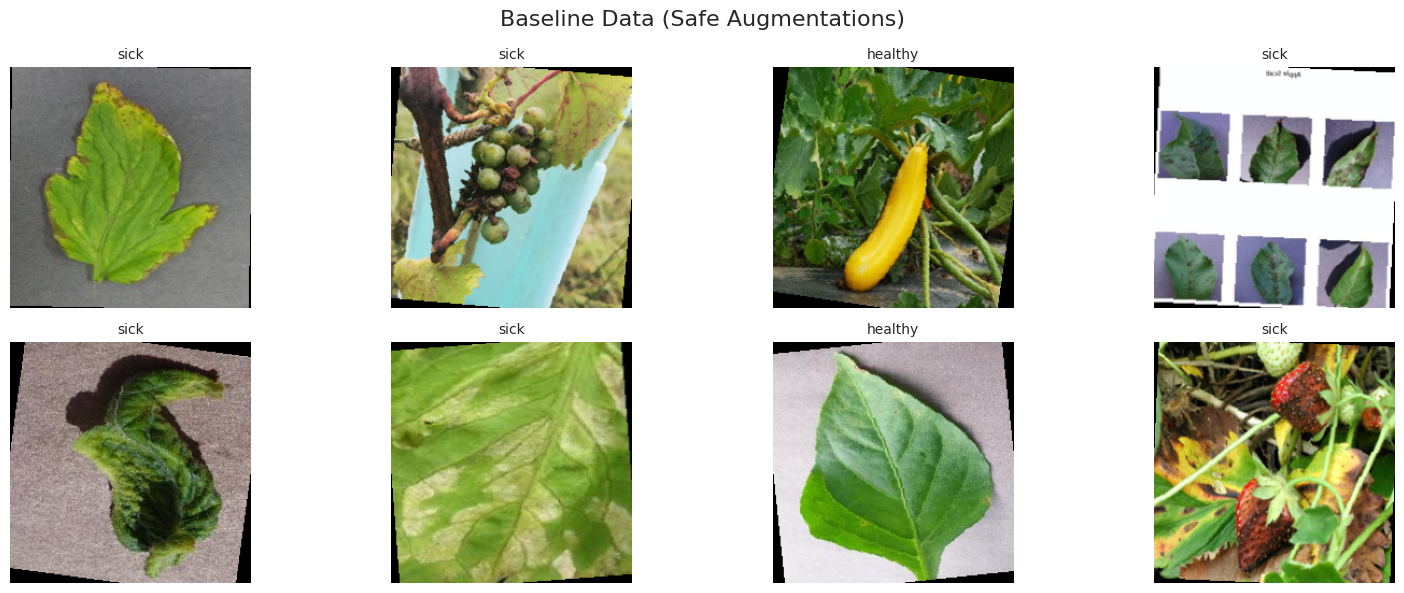

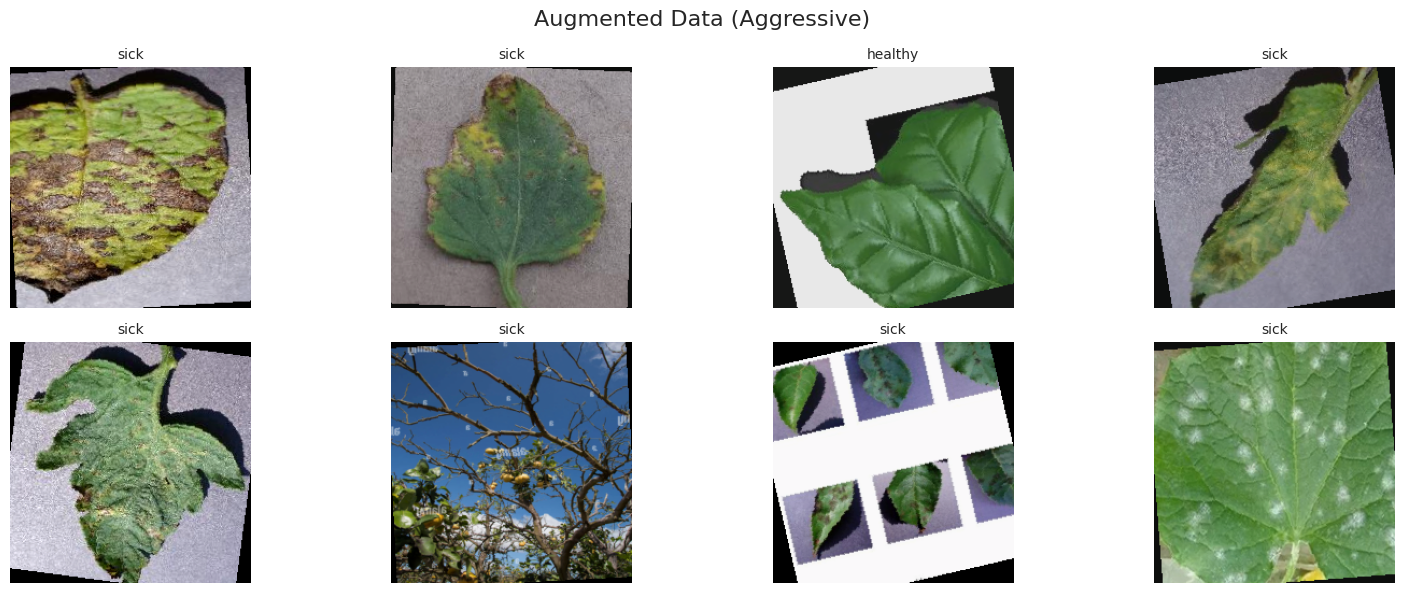

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show_sanity_check(loader, title="Sanity Check"):
    images, labels = next(iter(loader))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(16, 6))

    for i in range(min(8, len(images))):
        ax = plt.subplot(2, 4, i + 1)
        # tensor (C, H, W) -> numpy (H, W, C)
        img = images[i].permute(1, 2, 0).numpy()

        # Reverse normalisation: (X * std) + mean
        img = std * img + mean

        # Cut values fron 0 to 1
        img = np.clip(img, 0, 1)

        plt.imshow(img)

        # name classes
        try:
            class_name = loader.dataset.classes[labels[i]]
        except:
            class_name = str(labels[i].item()) # Unlabeled

        plt.title(f"{class_name}", fontsize=10)
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 1. Baseline
try:
    show_sanity_check(train_loader_baseline, "Baseline Data (Safe Augmentations)")
except NameError:
    print("loader_baseline not found.")

# 2. Augmented
try:
    show_sanity_check(train_loader_augmented, "Augmented Data (Aggressive)")
except NameError:
    print("loader_augmented not found.")

**CLIP Zero-Shot Baseline:** Apply a pre-trained CLIP model for zero-shot classification  using prompt engineering (e.g. “a photo of a healthy leaf”).




From metrics: **F2-score** <= because of important finding a unhealthy plants

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
 Loading CLIP...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 206MiB/s]


🏷 Packages classes: ['healthy', 'sick']
 Prompts: ['a photo of a healthy plant leaf', 'a photo of an unhealthy, diseased plant leaf']
Starts Zero-Shot Classification...
------------------------------
 Result CLIP Baseline:
Accuracy: 0.7800
F2 Score: 0.9122


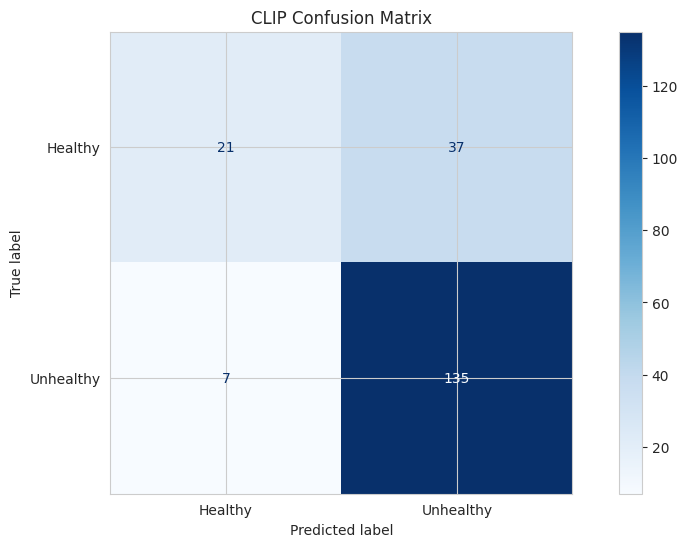

In [ ]:
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

import torch
import clip
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

# 2. LOADING CLIP
print(" Loading CLIP...")
model, preprocess = clip.load("ViT-B/32", device=device)

# 3. Data preparation
clip_dataset = datasets.ImageFolder(VAL_DIR, transform=preprocess)
clip_loader = DataLoader(clip_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"🏷 Packages classes: {clip_dataset.classes}")

# 4. Text prompts
text_prompts = [
    "a photo of a healthy plant leaf",            # 0
    "a photo of an unhealthy, diseased plant leaf" # 1
]
print(f" Prompts: {text_prompts}")

text_tokens = clip.tokenize(text_prompts).to(device)

# 5. Inference
y_true = []
y_pred = []

model.eval()
print("Starts Zero-Shot Classification...")

with torch.no_grad():
    for images, labels in clip_loader:
        images = images.to(device)
        labels = labels.to(device)

        # CLIP
        logits_per_image, _ = model(images, text_tokens)
        probs = logits_per_image.softmax(dim=-1)
        preds = probs.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 6. Мetrics
print("-" * 30)
acc = accuracy_score(y_true, y_pred)
f2 = fbeta_score(y_true, y_pred, beta=2)

print(f" Result CLIP Baseline:")
print(f"Accuracy: {acc:.4f}")
print(f"F2 Score: {f2:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Healthy", "Unhealthy"])
disp.plot(cmap='Blues')
plt.title("CLIP Confusion Matrix")
plt.show()

**CNN Architecture Selection:** Select a lightweight backbone (ResNet-18,  MobileNet-V2, EfficientNet-B0) suitable for fast experimentation.

Chosen: ResNet-18



1.   Stability
2.   Many depend on mistake
3.   Good for small datasets


**CNN Training:** Train the CNN on labeled data using standard hyperparameters, optimizer (AdamW), and basic evaluation metrics.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torchvision import models
from sklearn.utils.class_weight import compute_class_weight

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#TRAINING LOOP
def train_experiment(model, train_loader, val_loader, epochs=10):

    since = time.time()

    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

    train_targets = train_loader.dataset.targets
    class_weights = compute_class_weight(
      class_weight='balanced',
      classes=np.unique(train_targets),
      y=train_targets)
    weight = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    model = model.to(DEVICE)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}', end=' ')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                print(f'| Val Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f' Best Val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

def get_fresh_resnet():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters(): # Freeze
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 2)
    )
    return model.to(DEVICE)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

def evaluate_and_plot(model, loader, class_names, title="Model Evaluation"):
    model.eval()
    y_true = []
    y_pred = []

    print(f" Analyze: {title}...")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = fbeta_score(y_true, y_pred, beta=1, pos_label=1)
    # F2:  Recall > Precision
    f2 = fbeta_score(y_true, y_pred, beta=2, pos_label=1)
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    print(report)

    print(f" {title} Results:")
    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1 Score: {f1:.4f} (Головна метрика)")
    print(f"    F2 Score: {f2:.4f} (Головна метрика)")

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax, values_format='d')

    plt.title(f"{title}\nF2: {f2:.3f}")
    plt.grid(False)
    plt.show()

    return f2

*TRAIN DATASET*

In [ ]:
class_names = val_loader.dataset.classes

print("\n" + "="*50)
print(" TRAINING BASELINE MODEL...")
print("="*50)

model_base = get_fresh_resnet()
best_model_base, hist_base = train_experiment(model_base, train_loader_baseline, val_loader, epochs=15)

torch.save(best_model_base.state_dict(), 'best_baseline_model.pth')
print(" Best Baseline model saved to 'best_baseline_model.pth'")

print("\n Evaluating Baseline on VALIDATION Set:")
val_f2_base = evaluate_and_plot(best_model_base, val_loader, class_names, title="Baseline (Val)")

print("\n Evaluating Baseline on TEST Set (Final Exam):")
test_f2_base = evaluate_and_plot(best_model_base, test_loader, class_names, title="Baseline (TEST)")

print("\n" + "="*50)
print(" TRAINING AUGMENTED MODEL...")
print("="*50)

model_aug = get_fresh_resnet()
best_model_aug, hist_aug = train_experiment(model_aug, train_loader_augmented, val_loader, epochs=15)

torch.save(best_model_aug.state_dict(), 'best_augmented_model.pth')
print(" Best Augmented model saved to 'best_augmented_model.pth'")

print("\n Evaluating Augmented on VALIDATION Set:")
val_f2_aug = evaluate_and_plot(best_model_aug, val_loader, class_names, title="Augmented (Val)")

print("\n Evaluating Augmented on TEST Set (Final Exam):")
test_f2_aug = evaluate_and_plot(best_model_aug, test_loader, class_names, title="Augmented (TEST)")

# SUMMERY
print("\n" + "="*50)
print(" FINAL RESULTS SUMMARY (Test Set F2-Score)")
print("="*50)
print(f"Baseline Test F2:  {test_f2_base:.4f}")
print(f"Augmented Test F2: {test_f2_aug:.4f}")

if test_f2_aug > test_f2_base:
    diff = (test_f2_aug - test_f2_base) * 100
    print(f"\n Augmentation is better on {diff:.2f}%")
else:
    print("\n Augmentation is worse on.")


 TRAINING BASELINE MODEL...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


Epoch 1/15 

KeyboardInterrupt: 

# Task – Advanced

**Training Optimization:** Tune learning rate, batch size, schedulers,
regularization, and handle class imbalance.

We significantly boosted the pipeline's robustness by **fine-tuning the last convolutional block** (layer 4) and adding **Dropout** to better adapt high-level features while preventing overfitting. On the optimization side, we addressed data imbalance via weighted **CrossEntropyLoss**, switched to **AdamW** with weight decay and gradient clipping for superior regularization and stability, and implemented a dynamic learning rate **scheduler (ReduceLROnPlateau)** alongside **Early Stopping** to ensure precise convergence without wasting resources on stagnant epochs.


In [ ]:
def get_optimized_resnet(fine_tune_last_block=True):
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    if fine_tune_last_block:
        for param in model.layer4.parameters():
            param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5), # (Dropout)
        nn.Linear(num_ftrs, 2)
    )

    return model.to(DEVICE)

In [ ]:
def train_experiment_optimized(model, train_loader, val_loader, epochs=20, patience=5):
    since = time.time()
    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

    # --- Handling Class Imbalance ---
    def get_targets(dataset):
        if hasattr(dataset, 'targets'):
            # Для ImageFolder
            return dataset.targets
        elif hasattr(dataset, 'tensors'):
            # Для TensorDataset
            return dataset.tensors[1].cpu().numpy()
        elif hasattr(dataset, 'datasets'):
            # Для ConcatDataset
            all_targets = []
            for ds in dataset.datasets:
                all_targets.extend(get_targets(ds))
            return all_targets
        else:
            print(" Warning: Iterating dataset to find targets (slow)...")
            return [y for _, y in dataset]

    train_targets = get_targets(train_loader.dataset)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_targets),
        y=train_targets
    )
    weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    print(f" Class Weights calculated: {class_weights}")

    # --- Loss, Optimizer, Scheduler ---
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)

    # AdamW
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=3e-4,
                            weight_decay=1e-4) # L2 Regularization

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0 # Можно отслеживать F1 вместо Acc

    # Early Stopping variables
    epochs_no_improve = 0

    model = model.to(DEVICE)

    print(f" Start Training on {DEVICE}...")

    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # Optional: Gradient Clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep Copy Model & Scheduler Step
            if phase == 'val':
                current_lr = optimizer.param_groups[0]['lr']
                scheduler.step(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0 # Сброс счетчика
                    print(f" New Best Val Acc: {best_acc:.4f}")
                else:
                    epochs_no_improve += 1
                    print(f" No improvement for {epochs_no_improve} epochs.")

        # Early Stopping Check
        if epochs_no_improve >= patience:
            print(f"\n Early stopping triggered! No improvement for {patience} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
class_names = val_loader.dataset.classes

print("\n" + "="*50)
print(" TRAINING OPTIMIZED MODEL (AUGMENTED)...")
print("="*50)

model_opt = get_optimized_resnet(fine_tune_last_block=True)

best_model_opt, hist_opt = train_experiment_optimized(
    model_opt,
    train_loader_augmented,
    val_loader,
    epochs=25,
    patience=5
)

torch.save(best_model_opt.state_dict(), 'best_optimized_model.pth')
print(" Best Optimized model saved.")

print("\n Evaluating Optimized on TEST Set:")
test_f2_opt = evaluate_and_plot(best_model_opt, test_loader, class_names, title="Optimized Model (TEST)")


 TRAINING OPTIMIZED MODEL (AUGMENTED)...
 Class Weights calculated: [1.77514793 0.69605568]
 Start Training on cpu...

Epoch 1/25
----------


KeyboardInterrupt: 

**Pseudo-Labeling and Expanded Retraining:** Generate labels for unlabeled data using CNN and/or CLIP predictions and filter high-confidence samples. Retrain the model on the combined dataset (ground-truth + pseudo-labeled samples) and compare performance gains.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np

class PseudoLabelDataset(Dataset):
    def __init__(self, data_tensors, target_tensors):
        self.data = data_tensors
        # Зберігаємо targets як список або масив для сумісності з логікою зважування класів
        self.targets = target_tensors.tolist() if torch.is_tensor(target_tensors) else target_tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        target = self.targets[idx]
        return img, target

def generate_pseudo_labels(model, unlabeled_loader, threshold=0.90, device=DEVICE):
    model.eval()
    pseudo_images = []
    pseudo_labels = []

    print(f" Generating pseudo-labels with threshold {threshold}...")

    with torch.no_grad():
        for inputs, _ in unlabeled_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

            mask = max_probs > threshold

            if mask.sum() > 0:
                pseudo_images.append(inputs[mask].cpu())
                pseudo_labels.append(preds[mask].cpu())

    if len(pseudo_images) == 0:
        print(" No pseudo-labels generated!")
        return None

    all_images = torch.cat(pseudo_images)
    all_labels = torch.cat(pseudo_labels)

    print(f" Generated {len(all_labels)} pseudo-labeled samples.")

    return PseudoLabelDataset(all_images, all_labels)

In [ ]:
# ==========================================
# EXECUTION PIPELINE
# ==========================================

print("\n" + "="*50)
print(" 1. TRAINING TEACHER MODEL (Baseline)...")
print("="*50)

num_classes = len(train_loader_augmented.dataset.classes)
teacher_model = get_optimized_resnet(fine_tune_last_block=True)

teacher_model, _ = train_experiment_optimized(
    teacher_model,
    train_loader_augmented,
    val_loader,
    epochs=15,
    patience=5
)

print("\n" + "="*50)
print(" 2. GENERATING PSEUDO-LABELS...")
print("="*50)

pseudo_dataset = generate_pseudo_labels(teacher_model, unlabeled_loader, threshold=0.90)

if pseudo_dataset is not None:
    original_train_dataset = train_loader_augmented.dataset

    combined_dataset = ConcatDataset([original_train_dataset, pseudo_dataset])

    combined_loader = DataLoader(
        combined_dataset,
        batch_size=train_loader_augmented.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    print(f" Combined Dataset Size: {len(combined_dataset)} (Original: {len(original_train_dataset)})")

    print("\n" + "="*50)
    print(" 3. TRAINING STUDENT MODEL (Semi-Supervised)...")
    print("="*50)

    student_model = get_optimized_resnet(fine_tune_last_block=True)

    best_student_model, hist_student = train_experiment_optimized(
        student_model,
        combined_loader,
        val_loader,
        epochs=25,
        patience=5
    )

    torch.save(best_student_model.state_dict(), 'best_student_resnet.pth')

    print("\n Evaluating Student on TEST Set:")
    if 'evaluate_and_plot' in globals():
        evaluate_and_plot(best_student_model, test_loader, train_loader_augmented.dataset.classes, title="Student Model (Pseudo-Labeled)")
    else:
        print("Function 'evaluate_and_plot' not found. Skipping visualization.")

else:
    print("Skipping Step 3 because no pseudo-labels were confident enough.")

# Task – Expert

**Active Learning:** Select the most informative unlabeled samples using uncertainty-based sampling for simulated re-labeling.

In [ ]:
import torch
import numpy as np

def process_unlabeled_pool(model, unlabeled_loader,
                           pseudo_threshold=0.90,
                           n_active_samples=50,
                           device=DEVICE):

    model.eval()

    pseudo_images = []
    pseudo_labels = []

    cand_probs = []
    cand_images = []
    cand_true_labels = []

    pseudo_indices = []
    cand_indices = []

    current_idx_offset = 0

    print(f" Analyzing unlabeled pool...")

    with torch.no_grad():
        for inputs, true_targets in unlabeled_loader:
            inputs = inputs.to(device)
            true_targets = true_targets.to(device)
            batch_size = inputs.size(0)

            batch_indices = np.arange(current_idx_offset, current_idx_offset + batch_size)

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

            # --- 1. PSEUDO-LABELING ---
            mask_pseudo = max_probs > pseudo_threshold

            if mask_pseudo.sum() > 0:
                pseudo_images.append(inputs[mask_pseudo].cpu())
                pseudo_labels.append(preds[mask_pseudo].cpu())

                pseudo_indices.extend(batch_indices[mask_pseudo.cpu().numpy()])

            # --- 2. CANDIDATES FOR ACTIVE LEARNING ---
            mask_uncertain = ~mask_pseudo

            if mask_uncertain.sum() > 0:
                cand_images.append(inputs[mask_uncertain].cpu())
                cand_true_labels.append(true_targets[mask_uncertain].cpu())
                cand_probs.append(probs[mask_uncertain].cpu())

                cand_indices.extend(batch_indices[mask_uncertain.cpu().numpy()])

            current_idx_offset += batch_size

    # --- PSEUDO DATASET ---
    pseudo_dataset = None
    if len(pseudo_images) > 0:
        p_imgs = torch.cat(pseudo_images)
        p_lbls = torch.cat(pseudo_labels)
        pseudo_dataset = PseudoLabelDataset(p_imgs, p_lbls)
        print(f" Pseudo-Labeling: {len(pseudo_dataset)} samples.")

    # --- ACTIVE LEARNING (Entropy Sort) ---
    active_dataset = None
    active_indices_selected = []

    if len(cand_probs) > 0:

        all_probs = torch.cat(cand_probs)
        all_imgs = torch.cat(cand_images)
        all_true = torch.cat(cand_true_labels)
        all_candidate_indices = np.array(cand_indices)

        entropy = -(all_probs * torch.log(all_probs + 1e-10)).sum(dim=1)

        k = min(n_active_samples, len(entropy))
        top_vals, top_rel_indices = torch.topk(entropy, k)

        active_imgs = all_imgs[top_rel_indices]
        active_lbls = all_true[top_rel_indices]

        active_indices_selected = all_candidate_indices[top_rel_indices.cpu().numpy()]

        active_dataset = PseudoLabelDataset(active_imgs, active_lbls)
        print(f" Active Learning: {len(active_dataset)} samples selected.")

    consumed_indices = list(pseudo_indices) + list(active_indices_selected)

    return pseudo_dataset, active_dataset, consumed_indices

In [ ]:
from torch.utils.data import Subset, ConcatDataset

full_unlabeled_dataset = unlabeled_loader.dataset
processed_indices = set()

current_train_dataset = train_loader_augmented.dataset

CYCLES = 3

for cycle in range(CYCLES):
    print(f"\n{'='*20} CYCLE {cycle+1}/{CYCLES} {'='*20}")

    print(f" Training Model on {len(current_train_dataset)} samples...")
    train_loader = DataLoader(current_train_dataset, batch_size=32, shuffle=True, num_workers=2)

    model = get_optimized_resnet(fine_tune_last_block=True)
    model, _ = train_experiment_optimized(model, train_loader, val_loader, epochs=10, patience=3)

    all_indices = set(range(len(full_unlabeled_dataset)))
    remaining_indices = list(all_indices - processed_indices)

    if len(remaining_indices) == 0:
        print(" Unlabeled pool is empty! Stopping cycles.")
        break

    current_unlabeled_subset = Subset(full_unlabeled_dataset, remaining_indices)

    cycle_unlabeled_loader = DataLoader(
        current_unlabeled_subset,
        batch_size=32,
        shuffle=False,
        num_workers=2
    )

    print(f" Selecting samples from remaining {len(remaining_indices)} images...")

    pseudo_ds, active_ds, new_local_indices = process_unlabeled_pool(
        model,
        cycle_unlabeled_loader,
        pseudo_threshold=0.95,
        n_active_samples=50
    )

    if new_local_indices:
        for local_idx in new_local_indices:
            global_idx = remaining_indices[local_idx]
            processed_indices.add(global_idx)

    datasets_to_combine = [current_train_dataset]

    if active_ds is not None:
        datasets_to_combine.append(active_ds)
        print(f"   + Added {len(active_ds)} active samples")

    if pseudo_ds is not None:
        datasets_to_combine.append(pseudo_ds)
        print(f"   + Added {len(pseudo_ds)} pseudo samples")

    current_train_dataset = ConcatDataset(datasets_to_combine)
    print(f" New Dataset Size: {len(current_train_dataset)}")

print("\n Final Evaluation on Test Set:")
evaluate_and_plot(model, test_loader, class_names)


==================== CYCLE 1/3 ====================
 Training Model on 600 samples...
 Class Weights calculated: [1.77514793 0.69605568]
 Start Training on cpu...

Epoch 1/10
----------


**Model Optimization (Quantization/Pruning):** Apply at least one optimization technique (e.g., quantization or pruning) and validate its impact on accuracy and latency.

In [ ]:
import time
import os
import torch
import torch.nn.utils.prune as prune
import numpy as np

print(f"\n{'='*20} MODEL OPTIMIZATION TASK {'='*20}")

def measure_performance(model, loader, device='cpu'):
    model.to(device)
    model.eval()

    torch.save(model.state_dict(), "temp_model.pth")
    size_mb = os.path.getsize("temp_model.pth") / (1024 * 1024)
    os.remove("temp_model.pth")

    start_time = time.time()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()
    accuracy = 100 * correct / total
    avg_latency = (end_time - start_time) / total * 1000

    return size_mb, accuracy, avg_latency

# ==========================================
# 1. BASELINE
# ==========================================
print(" Measuring Baseline Model...")
device_for_test = 'cpu'
base_size, base_acc, base_lat = measure_performance(model, test_loader, device=device_for_test)

print(f"Original -> Size: {base_size:.2f} MB | Acc: {base_acc:.2f}% | Latency: {base_lat:.2f} ms/img")

# ==========================================
# 2. PRUNING
# ==========================================
print("\n Applying Global Pruning (removing 20% of smallest weights)...")

parameters_to_prune = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        parameters_to_prune.append((module, 'weight'))

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

for module, _ in parameters_to_prune:
    prune.remove(module, 'weight')

# ==========================================
# 3. SUMMARY
# ==========================================
print(" Measuring Optimized Model...")
opt_size, opt_acc, opt_lat = measure_performance(model, test_loader, device=device_for_test)

print(f"Pruned   -> Size: {opt_size:.2f} MB | Acc: {opt_acc:.2f}% | Latency: {opt_lat:.2f} ms/img")

print("\n📝 SUMMARY:")
print(f"Size Reduction: {base_size - opt_size:.2f} MB ({(base_size - opt_size)/base_size*100:.1f}%)")
print(f"Accuracy Drop:  {base_acc - opt_acc:.2f}%")
print(f"Speedup:        {base_lat - opt_lat:.2f} ms faster per image")

In [ ]:
# ==========================================
# 2. DYNAMIC QUANTIZATION
# ==========================================
print("\n📦 Applying Dynamic Quantization (Float32 -> Int8)...")

quantized_model = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear},  # Указываем, какие слои сжимать
    dtype=torch.qint8
)

# ==========================================
# 3. VALIDATION
# ==========================================
print(" Measuring Optimized Model...")
opt_size, opt_acc, opt_lat = measure_performance(quantized_model, test_loader, device='cpu')

print(f"Quantized -> Size: {opt_size:.2f} MB | Acc: {opt_acc:.2f}% | Latency: {opt_lat:.2f} ms/img")

In [ ]:
# ==========================================
# 2. HALF PRECISION (FLOAT16)
# ==========================================
print("\n Converting to Float16 (Half Precision)...")

half_model = copy.deepcopy(model)
half_model.half()

# ==========================================
# 3. VALIDATION
# ==========================================
print(" Measuring Optimized Model...")

torch.save(half_model.state_dict(), "temp_half.pth")
opt_size = os.path.getsize("temp_half.pth") / (1024 * 1024)
os.remove("temp_half.pth")

device = 'cpu' # Или 'cuda' если есть
half_model.to(device)
half_model.eval()

correct = 0
total = 0
start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.half()

        outputs = half_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end_time = time.time()
opt_acc = 100 * correct / total
opt_lat = (end_time - start_time) / total * 1000

print(f"Float16  -> Size: {opt_size:.2f} MB | Acc: {opt_acc:.2f}% | Latency: {opt_lat:.2f} ms/img")

print("\n SUMMARY:")
print(f"Size Reduction: {base_size - opt_size:.2f} MB ({(base_size - opt_size)/base_size*100:.1f}%)")

**Explainability:** Use Grad-CAM or similar methods to visualize model
attention and decision regions.

In [ ]:
!pip install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

model_for_cam = best_model_opt
model_for_cam.eval()

target_layers = [model_for_cam.layer4[-1]]

cam = GradCAM(model=model_for_cam, target_layers=target_layers)

# /kaggle/working For Kaggle
img_path = '/content/train/healthy/train__03bc8804-bc25-4930-b9bf-35c35920dc3f___RS_HL 9940.JPG'


rgb_img = cv2.imread(img_path, 1)[:, :, ::-1] # BGR -> RGB
rgb_img = np.float32(rgb_img) / 255

input_tensor = torch.from_numpy(rgb_img).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

grayscale_cam = cam(input_tensor=input_tensor, targets=None)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

save_path = '/content/result_gradcam.jpg'
cv2.imwrite(save_path, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))
print(f" Готово! Результат сохранен в файл: {save_path}")

NameError: name 'best_model_opt' is not defined

In [ ]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('result_gradcam.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/content/train/healthy/train__03bc8804-bc25-4930-b9bf-35c35920dc3f___RS_HL 9940.JPG')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()